# Exploratory Data Analysis - US Flight Delay Data (BTS)

Jan, Apr, Jul, Oct 2025

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

## 1. Load and concatenate

In [104]:
files = [
    'T_ONTIME_REPORTING.csv',      # Jan
    'T_ONTIME_REPORTING-2.csv',    # Apr
    'T_ONTIME_REPORTING-3.csv',    # Jul
    'T_ONTIME_REPORTING-4.csv'     # Oct
]
df = pd.concat([pd.read_csv(f, low_memory=False) for f in files], ignore_index=True)

df['ARR_DELAY'] = pd.to_numeric(df['ARR_DELAY'], errors='coerce')
df['DEP_TIME'] = pd.to_numeric(df['DEP_TIME'], errors='coerce')
df['CANCELLED'] = pd.to_numeric(df['CANCELLED'], errors='coerce')

dep = pd.to_numeric(df['DEP_TIME'], errors='coerce')
df['DepHour'] = (dep // 100).clip(0, 23)

df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEP_TIME,...,ARR_TIME,ARR_DELAY,CANCELLED,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DepHour
0,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,10140,11298,452.0,...,733.0,-21.0,0.0,569.0,NaN,NaN,NaN,NaN,NaN,4.0
1,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,10140,11298,552.0,...,832.0,-17.0,0.0,569.0,NaN,NaN,NaN,NaN,NaN,5.0
2,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,10140,11298,815.0,...,1052.0,-22.0,0.0,569.0,NaN,NaN,NaN,NaN,NaN,8.0
3,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,10140,11298,1029.0,...,1300.0,-23.0,0.0,569.0,NaN,NaN,NaN,NaN,NaN,10.0
4,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,10140,11298,1707.0,...,2005.0,17.0,0.0,569.0,7.0,0.0,10.0,0.0,0.0,17.0


## 2. Basic info

In [105]:
print(f"Shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nDtypes:\n{df.dtypes}")
print(f"\nMissing values per column:")
df.isnull().sum()

Shape: (2360969, 21)

Column names:
['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DepHour']

Dtypes:
YEAR                     int64
QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
FL_DATE                 object
OP_UNIQUE_CARRIER       object
ORIGIN_AIRPORT_ID        int64
DEST_AIRPORT_ID          int64
DEP_TIME               float64
DEP_DELAY              float64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
DepHour                float6

YEAR                         0
QUARTER                      0
MONTH                        0
DAY_OF_MONTH                 0
DAY_OF_WEEK                  0
FL_DATE                      0
OP_UNIQUE_CARRIER            0
ORIGIN_AIRPORT_ID            0
DEST_AIRPORT_ID              0
DEP_TIME                 38079
DEP_DELAY                38203
ARR_TIME                 40551
ARR_DELAY                46589
CANCELLED                    0
DISTANCE                     0
CARRIER_DELAY          1849972
WEATHER_DELAY          1849972
NAS_DELAY              1849972
SECURITY_DELAY         1849972
LATE_AIRCRAFT_DELAY    1849972
DepHour                  38079
dtype: int64

## 3. ArrDelay distribution (target variable)

In [106]:
df_non_cancelled = df[df['CANCELLED'] != 1.0]
arr_delay_valid = df_non_cancelled['ARR_DELAY'].dropna()

print(f"Mean:   {arr_delay_valid.mean():.2f} min")
print(f"Median: {arr_delay_valid.median():.2f} min")
print(f"Std:    {arr_delay_valid.std():.2f} min")
pct_delayed_15 = (arr_delay_valid > 15).sum() / len(arr_delay_valid) * 100
print(f"\n% flights delayed > 15 min: {pct_delayed_15:.2f}%")

Mean:   8.31 min
Median: -6.00 min
Std:    59.55 min

% flights delayed > 15 min: 21.39%


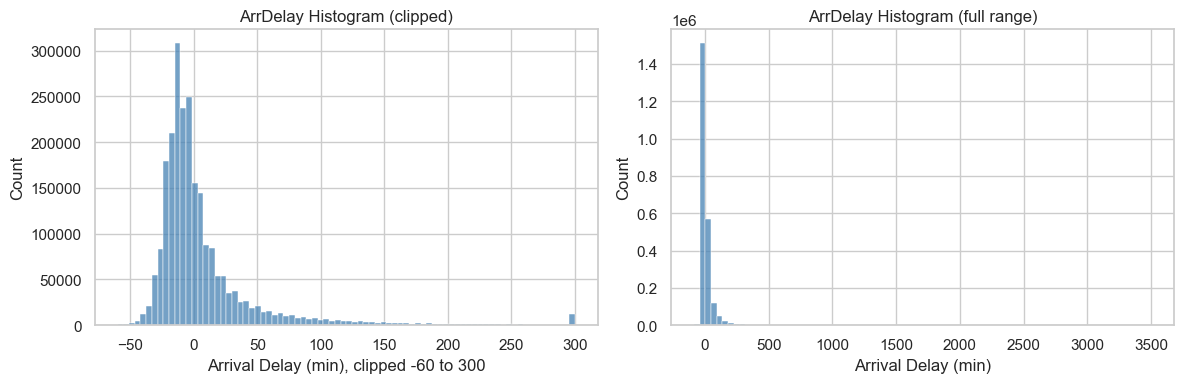

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(arr_delay_valid.clip(-60, 300), bins=80, ax=axes[0], kde=False, color='steelblue', edgecolor='white')
axes[0].set_xlabel('Arrival Delay (min), clipped -60 to 300')
axes[0].set_ylabel('Count')
axes[0].set_title('ArrDelay Histogram (clipped)')

sns.histplot(arr_delay_valid, bins=80, ax=axes[1], kde=False, color='steelblue', edgecolor='white')
axes[1].set_xlabel('Arrival Delay (min)')
axes[1].set_ylabel('Count')
axes[1].set_title('ArrDelay Histogram (full range)')
plt.tight_layout()
plt.show()

## 4. Delay rates by airline, origin (top 20), hour, month

In [108]:
df_delays = df_non_cancelled.copy()
df_delays['delayed_15'] = (df_delays['ARR_DELAY'] > 15).astype(int)

delay_by_airline = df_delays.groupby('OP_UNIQUE_CARRIER')['delayed_15'].mean() * 100
delay_by_airline = delay_by_airline.sort_values(ascending=False)

top20_origins = df['ORIGIN_AIRPORT_ID'].value_counts().head(20).index
df_top20 = df_delays[df_delays['ORIGIN_AIRPORT_ID'].isin(top20_origins)]
delay_by_origin = df_top20.groupby('ORIGIN_AIRPORT_ID')['delayed_15'].mean() * 100
delay_by_origin = delay_by_origin.reindex(top20_origins).sort_values(ascending=False)

delay_by_hour = df_delays.groupby('DepHour')['delayed_15'].mean() * 100
delay_by_month = df_delays.groupby('MONTH')['delayed_15'].mean() * 100

/var/folders/8y/g5hwjzvj0952_hwbybqjt6wh0000gn/T/ipykernel_66276/1989894.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delay_by_airline.index, y=delay_by_airline.values, ax=axes[0, 0], palette='Blues_d')
/var/folders/8y/g5hwjzvj0952_hwbybqjt6wh0000gn/T/ipykernel_66276/1989894.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delay_by_origin.index.astype(str), y=delay_by_origin.values, ax=axes[0, 1], palette='Greens_d')
/var/folders/8y/g5hwjzvj0952_hwbybqjt6wh0000gn/T/ipykernel_66276/1989894.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



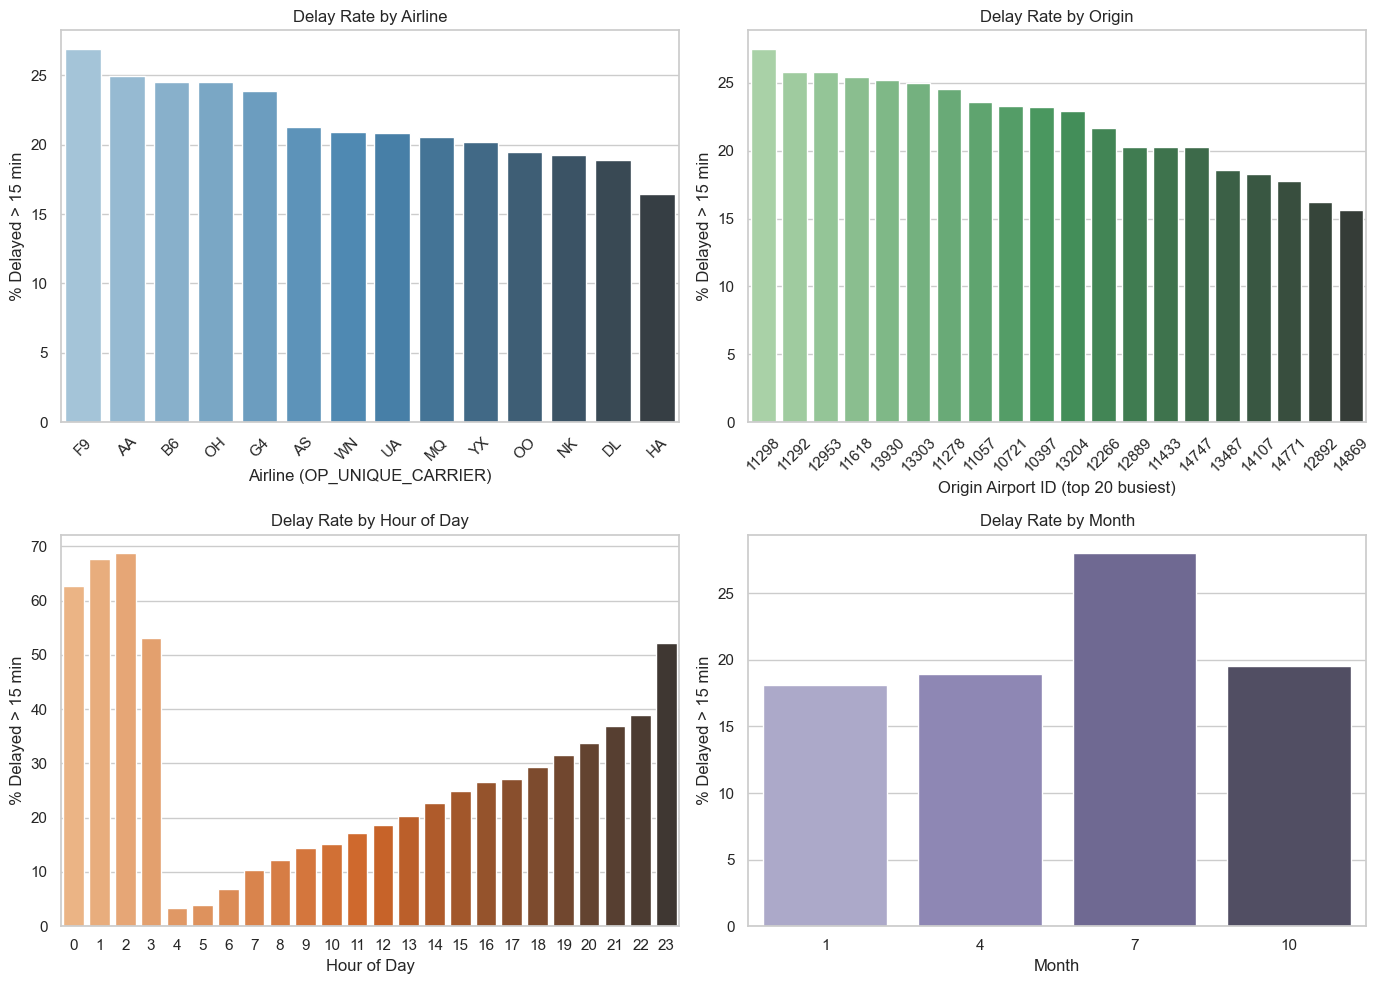

In [109]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(x=delay_by_airline.index, y=delay_by_airline.values, ax=axes[0, 0], palette='Blues_d')
axes[0, 0].set_xlabel('Airline (OP_UNIQUE_CARRIER)')
axes[0, 0].set_ylabel('% Delayed > 15 min')
axes[0, 0].set_title('Delay Rate by Airline')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.barplot(x=delay_by_origin.index.astype(str), y=delay_by_origin.values, ax=axes[0, 1], palette='Greens_d')
axes[0, 1].set_xlabel('Origin Airport ID (top 20 busiest)')
axes[0, 1].set_ylabel('% Delayed > 15 min')
axes[0, 1].set_title('Delay Rate by Origin')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.barplot(x=delay_by_hour.index.astype(int), y=delay_by_hour.values, ax=axes[1, 0], palette='Oranges_d')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('% Delayed > 15 min')
axes[1, 0].set_title('Delay Rate by Hour of Day')
axes[1, 0].tick_params(axis='x', rotation=0)

sns.barplot(x=delay_by_month.index, y=delay_by_month.values, ax=axes[1, 1], palette='Purples_d')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('% Delayed > 15 min')
axes[1, 1].set_title('Delay Rate by Month')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 5. Correlation with ArrDelay

In [110]:
numeric_cols = [
    'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
    'DEP_DELAY', 'ARR_DELAY', 'DISTANCE',
    'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'
]
df_numeric = df_non_cancelled[numeric_cols].copy()
for c in ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']:
    df_numeric[c] = pd.to_numeric(df_numeric[c], errors='coerce')

corr_with_target = df_numeric.corr()['ARR_DELAY'].drop('ARR_DELAY').sort_values(ascending=False)
print("Correlation with ARR_DELAY:")
corr_with_target

Correlation with ARR_DELAY:


DEP_DELAY              0.969299
CARRIER_DELAY          0.666946
LATE_AIRCRAFT_DELAY    0.525666
WEATHER_DELAY          0.310747
NAS_DELAY              0.215411
QUARTER                0.030523
MONTH                  0.030523
SECURITY_DELAY         0.016453
DAY_OF_WEEK            0.012390
DISTANCE              -0.012567
DAY_OF_MONTH          -0.016888
YEAR                        NaN
Name: ARR_DELAY, dtype: float64

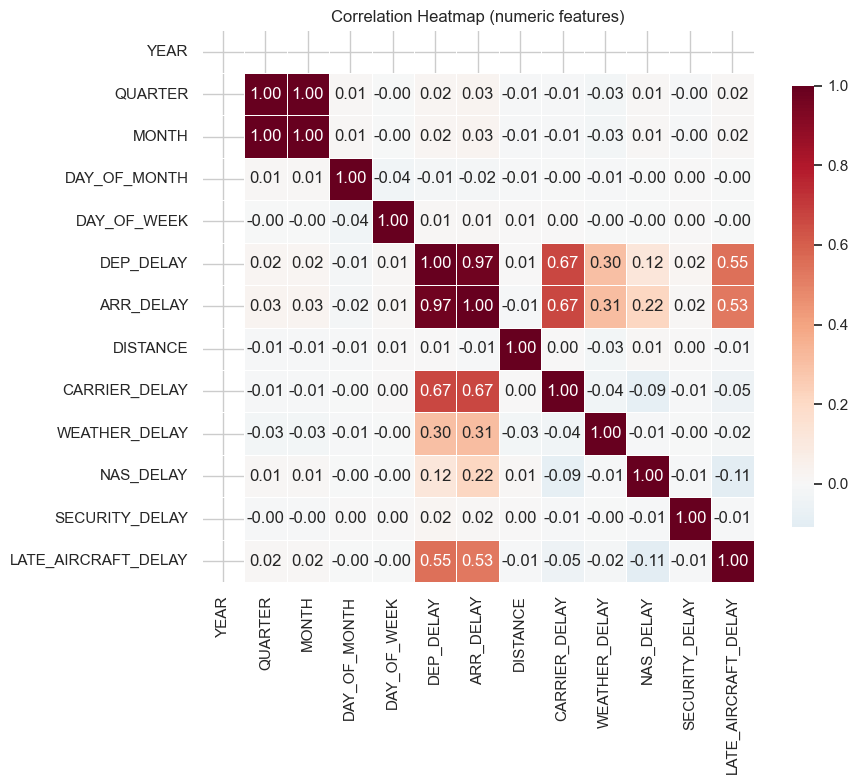

In [111]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
ax.set_title('Correlation Heatmap (numeric features)')
plt.tight_layout()
plt.show()

## 6. Cancellation rate

In [112]:
cancel_overall = df['CANCELLED'].mean() * 100
print(f"Overall cancellation rate: {cancel_overall:.2f}%")

cancel_by_airline = df.groupby('OP_UNIQUE_CARRIER')['CANCELLED'].mean() * 100
cancel_by_airline = cancel_by_airline.sort_values(ascending=False)
print("\nCancellation rate by airline:")
cancel_by_airline

Overall cancellation rate: 1.69%

Cancellation rate by airline:


OP_UNIQUE_CARRIER
OH    4.716689
YX    3.953363
MQ    2.378550
AA    2.266514
B6    2.078924
F9    1.733991
NK    1.691388
AS    1.547075
DL    1.223245
WN    1.172707
OO    1.126315
UA    1.075651
HA    1.058260
G4    0.438292
Name: CANCELLED, dtype: float64

/var/folders/8y/g5hwjzvj0952_hwbybqjt6wh0000gn/T/ipykernel_66276/3190870060.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancel_by_airline.index, y=cancel_by_airline.values, ax=ax, palette='Reds_d')


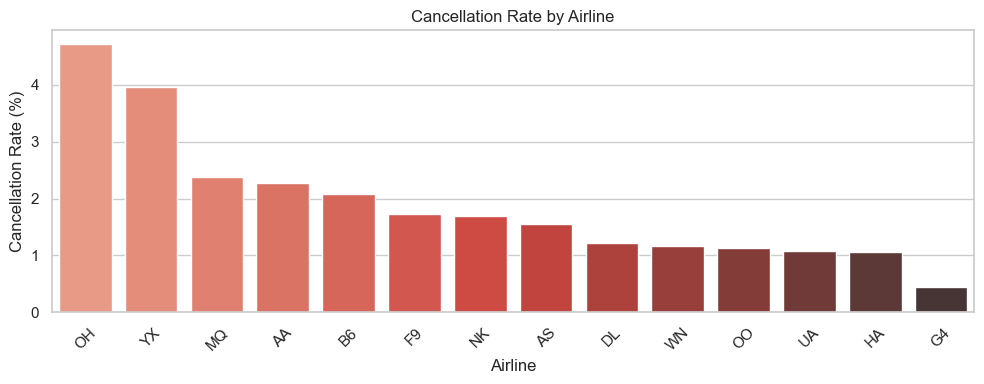

In [113]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x=cancel_by_airline.index, y=cancel_by_airline.values, ax=ax, palette='Reds_d')
ax.set_xlabel('Airline')
ax.set_ylabel('Cancellation Rate (%)')
ax.set_title('Cancellation Rate by Airline')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 7. Data quality flags

In [114]:
arr_delay_outliers_high = (arr_delay_valid > 500).sum()
arr_delay_outliers_low = (arr_delay_valid < -60).sum()
print(f"ARR_DELAY outliers (> 500 min): {arr_delay_outliers_high}")
print(f"ARR_DELAY outliers (< -60 min): {arr_delay_outliers_low}")
if arr_delay_outliers_high > 0:
    print(f"  Examples > 500: {arr_delay_valid[arr_delay_valid > 500].head(5).tolist()}")

dep_nan = df['DEP_TIME'].isna().sum()
dep_invalid = ((df['DEP_TIME'] < 0) | (df['DEP_TIME'] > 2359)).sum()
print(f"\nDEP_TIME: {dep_nan} NaN, {dep_invalid} invalid (outside 0-2359)")

cancelled_valid = df['CANCELLED'].dropna()
cancelled_bad = ~cancelled_valid.isin([0.0, 1.0])
print(f"\nCANCELLED: {cancelled_bad.sum()} values not in {{0, 1}}")

neg_dist = (df['DISTANCE'] < 0).sum()
print(f"\nDISTANCE: {neg_dist} negative values")

null_pct = df.isnull().sum() / len(df) * 100
high_null = null_pct[null_pct > 50]
print(f"\nColumns with >50% nulls: {list(high_null.index)}")

ARR_DELAY outliers (> 500 min): 4575
ARR_DELAY outliers (< -60 min): 339
  Examples > 500: [1610.0, 1406.0, 1481.0, 867.0, 601.0]

DEP_TIME: 38079 NaN, 257 invalid (outside 0-2359)

CANCELLED: 0 values not in {0, 1}

DISTANCE: 0 negative values

Columns with >50% nulls: ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']


/var/folders/8y/g5hwjzvj0952_hwbybqjt6wh0000gn/T/ipykernel_66276/4017344775.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=null_pct_sorted.values, y=null_pct_sorted.index, ax=ax, palette='viridis')


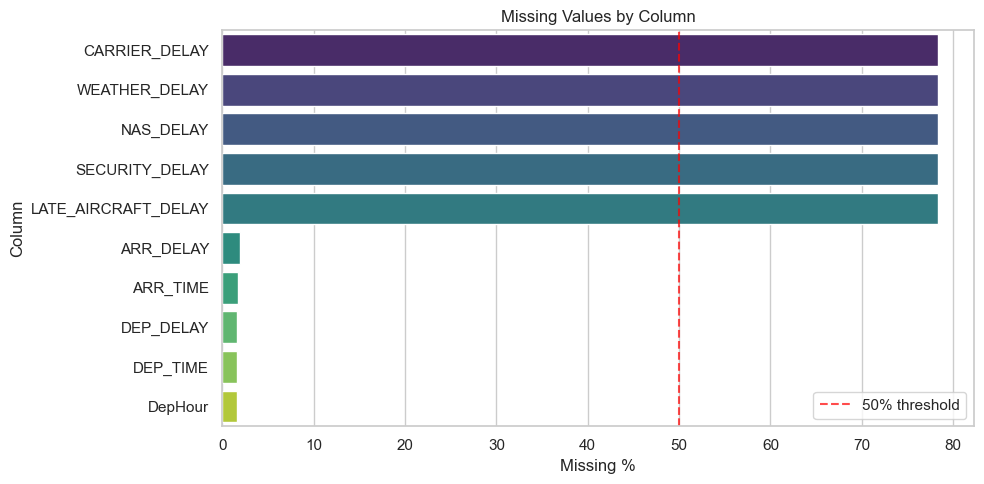

In [115]:
# Visualize missing value % per column
null_pct_sorted = df.isnull().sum() / len(df) * 100
null_pct_sorted = null_pct_sorted[null_pct_sorted > 0].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=null_pct_sorted.values, y=null_pct_sorted.index, ax=ax, palette='viridis')
ax.set_xlabel('Missing %')
ax.set_ylabel('Column')
ax.set_title('Missing Values by Column')
ax.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
ax.legend()
plt.tight_layout()
plt.show()

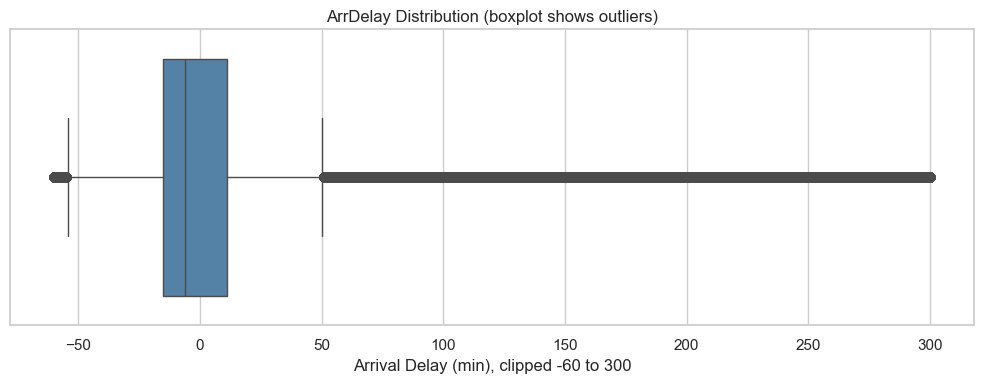

In [116]:
# ArrDelay distribution with outlier visualization
fig, ax = plt.subplots(figsize=(10, 4))
arr_plot = arr_delay_valid.clip(-60, 300)
sns.boxplot(x=arr_plot, ax=ax, color='steelblue')
ax.set_xlabel('Arrival Delay (min), clipped -60 to 300')
ax.set_title('ArrDelay Distribution (boxplot shows outliers)')
plt.tight_layout()
plt.show()

## 8. Summary

In [117]:
print("SUMMARY OF FINDINGS")
print("=" * 60)
print(f"""
Dataset: {len(df):,} flights across Jan, Apr, Jul, Oct 2025.

Arrival Delay (target):
  - Mean {arr_delay_valid.mean():.1f} min, median {arr_delay_valid.median():.1f} min, std {arr_delay_valid.std():.1f} min.
  - {pct_delayed_15:.1f}% of flights delayed > 15 min (classification threshold).

Delay rates:
  - Highest delay airline: {delay_by_airline.index[0]} ({delay_by_airline.iloc[0]:.1f}% delayed > 15 min).
  - Lowest delay airline: {delay_by_airline.index[-1]} ({delay_by_airline.iloc[-1]:.1f}% delayed > 15 min).
  - Worst hour: {int(delay_by_hour.idxmax())}:00 ({delay_by_hour.max():.1f}% delayed > 15 min).
  - Best hour: {int(delay_by_hour.idxmin())}:00 ({delay_by_hour.min():.1f}% delayed > 15 min).

Cancellation: {cancel_overall:.2f}% overall.

Data quality:
  - Columns with >50% nulls: {', '.join(high_null.index.tolist())}.
  - ARR_DELAY outliers: {arr_delay_outliers_high} > 500 min, {arr_delay_outliers_low} < -60 min.
  - DEP_DELAY is highly correlated with ARR_DELAY (use for modeling).
""")

SUMMARY OF FINDINGS

Dataset: 2,360,969 flights across Jan, Apr, Jul, Oct 2025.

Arrival Delay (target):
  - Mean 8.3 min, median -6.0 min, std 59.6 min.
  - 21.4% of flights delayed > 15 min (classification threshold).

Delay rates:
  - Highest delay airline: F9 (26.9% delayed > 15 min).
  - Lowest delay airline: HA (16.5% delayed > 15 min).
  - Worst hour: 2:00 (68.7% delayed > 15 min).
  - Best hour: 4:00 (3.4% delayed > 15 min).

Cancellation: 1.69% overall.

Data quality:
  - Columns with >50% nulls: CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY.
  - ARR_DELAY outliers: 4575 > 500 min, 339 < -60 min.
  - DEP_DELAY is highly correlated with ARR_DELAY (use for modeling).



## Model Training

### Data preparation

In [118]:
# Drop leaky/sparse columns
drop_cols = [
    'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
    'DEP_DELAY', 'ARR_TIME', 'DEP_TIME'
]
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Create binary target
df_model['is_delayed'] = (df_model['ARR_DELAY'] > 15).astype(int)

# Drop rows where ARR_DELAY is null
df_model = df_model.dropna(subset=['ARR_DELAY'])

# Use ORIGIN_AIRPORT_ID and DEST_AIRPORT_ID as ORIGIN, DEST (data has airport IDs, not codes)
df_model['ORIGIN'] = df_model['ORIGIN_AIRPORT_ID']
df_model['DEST'] = df_model['DEST_AIRPORT_ID']

# Select features
feature_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'MONTH', 'DAY_OF_WEEK', 'DAY_OF_MONTH', 'DepHour', 'DISTANCE']
X = df_model[feature_cols]
y = df_model['is_delayed']

# Handle DepHour NaN (from missing DEP_TIME) - fill with median
X['DepHour'] = X['DepHour'].fillna(X['DepHour'].median())

print(f"Shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Shape: (2314380, 8)
Target distribution:
is_delayed
0    1819374
1     495006
Name: count, dtype: int64


/var/folders/8y/g5hwjzvj0952_hwbybqjt6wh0000gn/T/ipykernel_66276/1870063060.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['DepHour'] = X['DepHour'].fillna(X['DepHour'].median())


In [119]:
from sklearn.preprocessing import LabelEncoder

# Label encode categorical columns (handle as strings for consistency)
encoders = {}
for col in ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

print("Label encoders fitted for: OP_UNIQUE_CARRIER, ORIGIN, DEST")
X.head()

/var/folders/8y/g5hwjzvj0952_hwbybqjt6wh0000gn/T/ipykernel_66276/680052964.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/8y/g5hwjzvj0952_hwbybqjt6wh0000gn/T/ipykernel_66276/680052964.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))


Label encoders fitted for: OP_UNIQUE_CARRIER, ORIGIN, DEST


/var/folders/8y/g5hwjzvj0952_hwbybqjt6wh0000gn/T/ipykernel_66276/680052964.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))


,OP_UNIQUE_CARRIER,ORIGIN,DEST,MONTH,DAY_OF_WEEK,DAY_OF_MONTH,DepHour,DISTANCE
0,0,2,90,1,3,1,4.0,569.0
1,0,2,90,1,3,1,5.0,569.0
2,0,2,90,1,3,1,8.0,569.0
3,0,2,90,1,3,1,10.0,569.0
4,0,2,90,1,3,1,17.0,569.0


### Model

In [120]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM parameters (no early stopping)
params = {
    'objective': 'binary',
    'scale_pos_weight': sum(y_train == 0) / sum(y_train == 1),
    'learning_rate': 0.05,
    'num_leaves': 63,
    'min_child_samples': 20,
    'n_estimators': 300,
    'random_state': 42
}

model = lgb.LGBMClassifier(**params, verbose=-1)
model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05, n_estimators=300, num_leaves=63,
               objective='binary', random_state=42,
               scale_pos_weight=3.671150692534753, verbose=-1)

### Evaluation

In [121]:
# Try different classification thresholds
proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, proba)
print(f"ROC-AUC (same for all thresholds): {roc_auc:.4f}\n")

for thresh in [0.35, 0.40, 0.45, 0.50]:
    y_pred_t = (proba > thresh).astype(int)
    print(f"--- Threshold = {thresh} ---")
    print(classification_report(y_test, y_pred_t))
    print()

ROC-AUC (same for all thresholds): 0.7685

--- Threshold = 0.35 ---
              precision    recall  f1-score   support

           0       0.93      0.41      0.57    364240
           1       0.29      0.89      0.44     98636

    accuracy                           0.51    462876
   macro avg       0.61      0.65      0.50    462876
weighted avg       0.80      0.51      0.54    462876


--- Threshold = 0.4 ---
              precision    recall  f1-score   support

           0       0.92      0.52      0.66    364240
           1       0.32      0.83      0.46     98636

    accuracy                           0.58    462876
   macro avg       0.62      0.67      0.56    462876
weighted avg       0.79      0.58      0.62    462876


--- Threshold = 0.45 ---
              precision    recall  f1-score   support

           0       0.91      0.62      0.73    364240
           1       0.35      0.76      0.48     98636

    accuracy                           0.65    462876
   macro 

In [122]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Use lower threshold (0.3) instead of default 0.5
y_pred = (model.predict_proba(X_test)[:, 1] > 0.1).astype(int)

print("Classification Report (threshold=0.4):")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.4f}")

Classification Report (threshold=0.4):
              precision    recall  f1-score   support

           0       0.99      0.03      0.06    364240
           1       0.22      1.00      0.36     98636

    accuracy                           0.24    462876
   macro avg       0.60      0.51      0.21    462876
weighted avg       0.82      0.24      0.12    462876


ROC-AUC Score: 0.7685


/var/folders/8y/g5hwjzvj0952_hwbybqjt6wh0000gn/T/ipykernel_66276/2718340633.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp, x='importance', y='feature', ax=ax, palette='Blues_d')


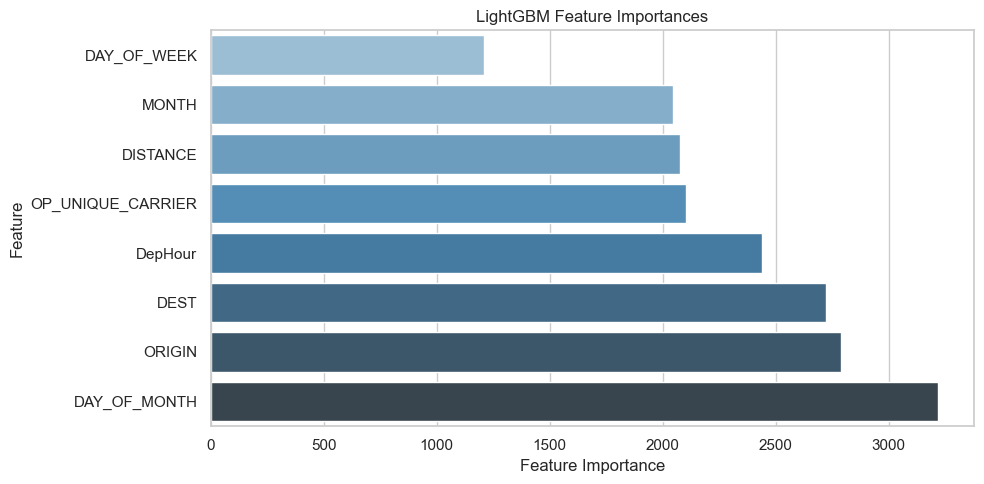

In [123]:
# Feature importances bar chart
imp = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=imp, x='importance', y='feature', ax=ax, palette='Blues_d')
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
ax.set_title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()

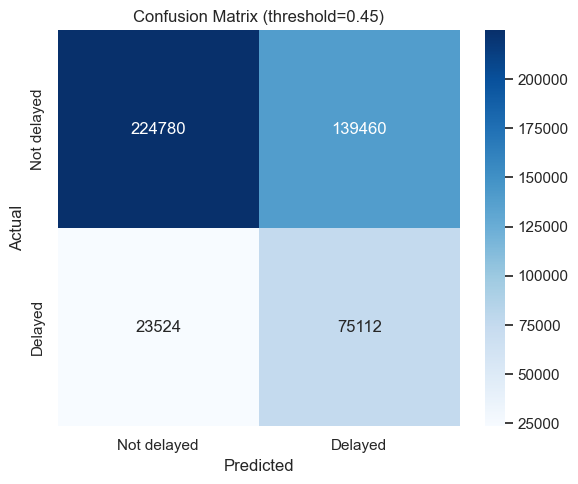

In [124]:
# Confusion matrix (threshold=0.45)
THRESHOLD = 0.45
y_pred_45 = (model.predict_proba(X_test)[:, 1] > THRESHOLD).astype(int)
cm = confusion_matrix(y_test, y_pred_45)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Not delayed', 'Delayed'],
            yticklabels=['Not delayed', 'Delayed'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix (threshold={THRESHOLD})')
plt.tight_layout()
plt.show()

### Save

In [125]:
import joblib

joblib.dump(model, 'model.pkl')
joblib.dump(encoders, 'encoders.pkl')

print("Saved: model.pkl, encoders.pkl")

Saved: model.pkl, encoders.pkl
